# Double pendulum motion analysis

*Nathan Keim, April 2019*

This notebook shows how to 
* Find features in a single frame of the double pendulum with colored markers.
* Visualize the chaotic motion of the double pendulum.

In [1]:
import numpy as np
import pims, skimage
import skimage.morphology
from matplotlib import pyplot as pl
import pandas as pd

# Develop image analysis

In [2]:
frames = pims.open('dbl_pend_images/*.png')

frames

<Frames>
Source: /Users/nkeim/Dropbox/research/PyData SLO, April 2019/mvdemo/dbl_pend_images/*.png
Length: 5 frames
Frame Shape: (720, 1280, 3)
Pixel Datatype: uint8

In [3]:
print(frames[0])  # the first frame

[[[189 167 157]
  [189 167 157]
  [189 167 157]
  ...
  [250 232 225]
  [250 232 225]
  [250 232 225]]

 [[188 166 156]
  [188 166 156]
  [188 166 156]
  ...
  [250 232 225]
  [250 232 225]
  [250 232 225]]

 [[185 163 153]
  [185 163 153]
  [185 163 153]
  ...
  [252 232 225]
  [252 232 225]
  [252 232 225]]

 ...

 [[140 107  99]
  [140 107  99]
  [140 107  99]
  ...
  [191 162 155]
  [194 165 158]
  [195 166 159]]

 [[141 109 101]
  [141 109 101]
  [141 109 101]
  ...
  [194 165 156]
  [196 167 158]
  [197 168 159]]

 [[141 109 101]
  [141 109 101]
  [141 109 101]
  ...
  [194 165 156]
  [196 167 158]
  [197 168 159]]]


Frame([[[188, 168, 155],
        [188, 168, 155],
        [188, 168, 155],
        ...,
        [253, 233, 226],
        [252, 232, 225],
        [252, 232, 225]],

       [[187, 167, 154],
        [187, 167, 154],
        [187, 167, 154],
        ...,
        [253, 233, 226],
        [252, 232, 225],
        [252, 232, 225]],

       [[187, 167, 154],
        [187, 167, 154],
        [187, 167, 154],
        ...,
        [252, 232, 225],
        [252, 232, 225],
        [252, 232, 225]],

       ...,

       [[140, 107, 103],
        [140, 107, 103],
        [140, 107, 103],
        ...,
        [192, 164, 162],
        [187, 162, 159],
        [187, 162, 159]],

       [[141, 108, 104],
        [141, 108, 104],
        [141, 108, 104],
        ...,
        [192, 167, 164],
        [188, 165, 164],
        [188, 165, 164]],

       [[141, 108, 104],
        [141, 108, 104],
        [141, 108, 104],
        ...,
        [192, 167, 164],
        [188, 165, 164],
        [188, 165, 164]]], dtype=uint8)
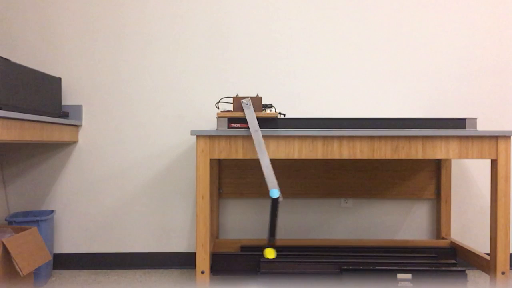

In [4]:
im = frames[4]
im

## Examine HSV representation

* Since markers are bright colors, look at color ("hue") of each pixel.
* Use "HSV" (hue, saturation, luminance) representation of color.

*The mapping from the RGB of the camera to HSV is not always well-defined, so we may get some warnings.*

In [5]:
hsv = skimage.color.rgb2hsv(im)
hue, saturation, luminance = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

/Users/nkeim/anaconda/envs/trackpy-examples/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/Users/nkeim/anaconda/envs/trackpy-examples/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


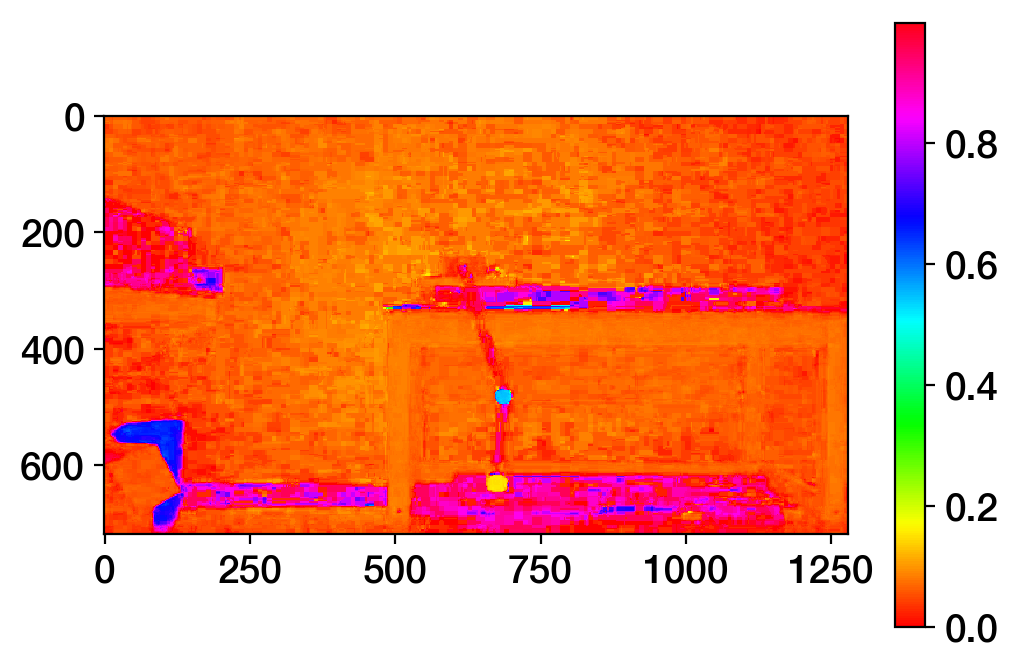

In [6]:
pl.imshow(hue, cmap=pl.cm.hsv)
pl.colorbar()

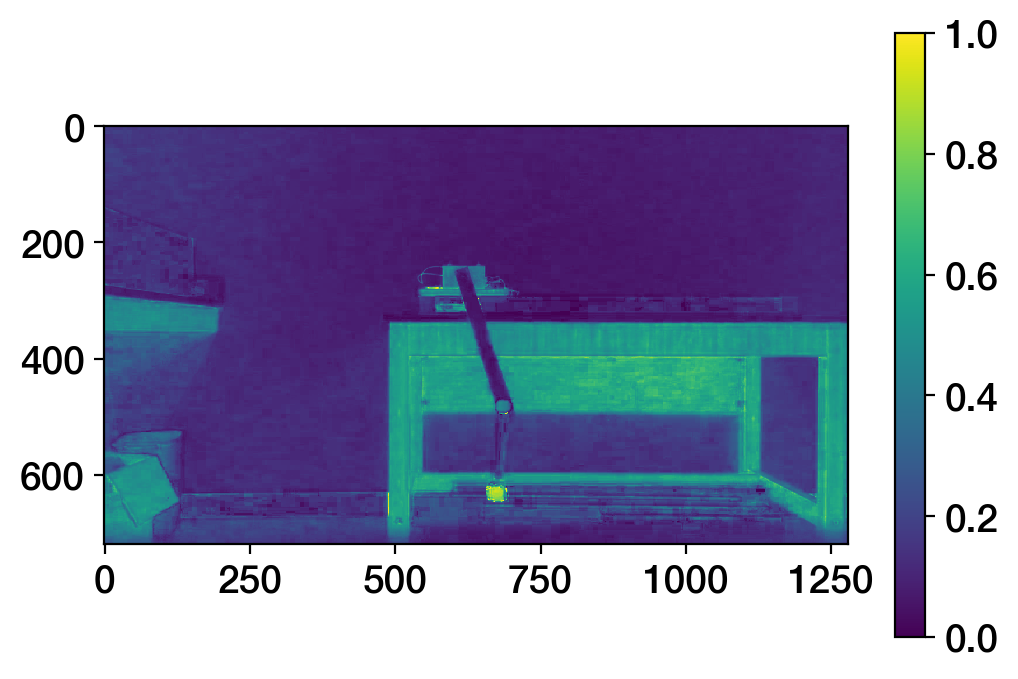

In [7]:
pl.imshow(saturation)
pl.colorbar()

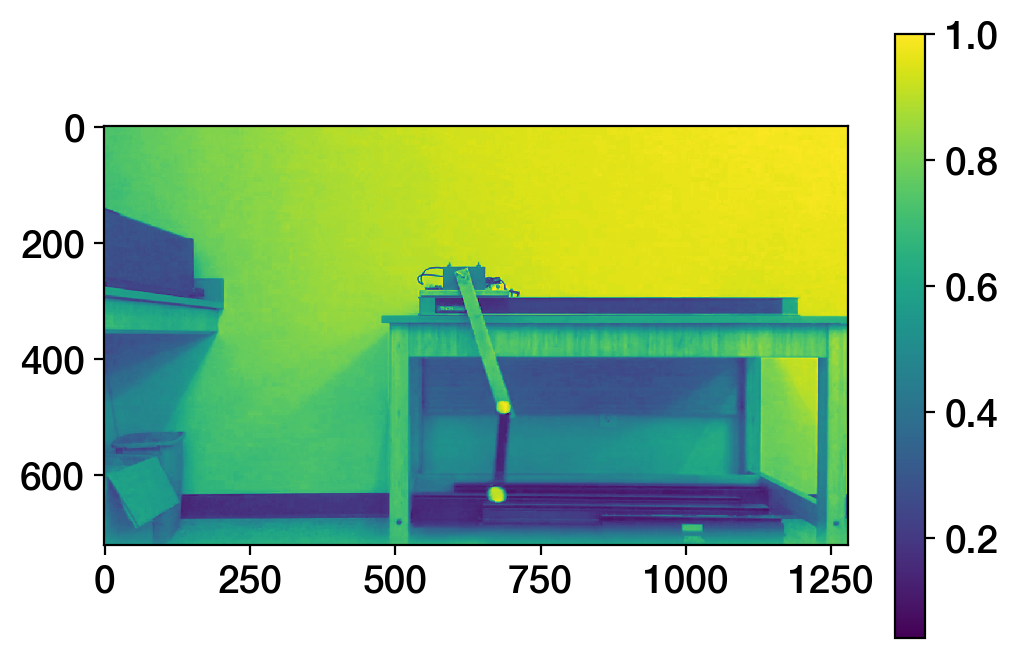

In [8]:
pl.imshow(luminance)
pl.colorbar()

### Distinguish markers

"Knee" is pale blue

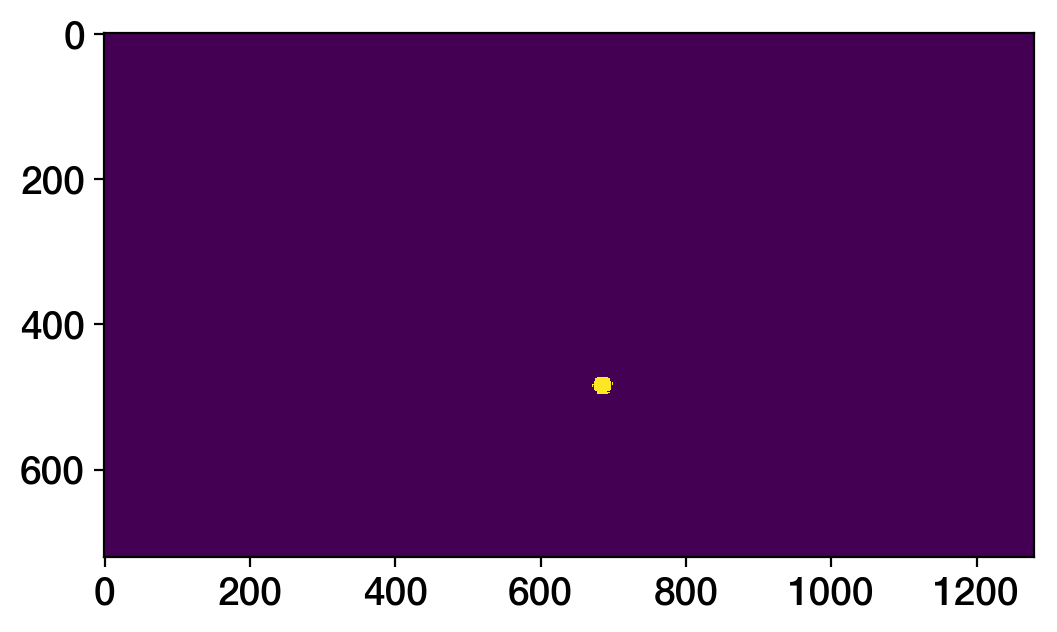

In [9]:
im_knee = (saturation >= 0.2) & (hue > 0.4) & (hue < 0.6)
pl.imshow(im_knee)

"Foot" is bright yellow

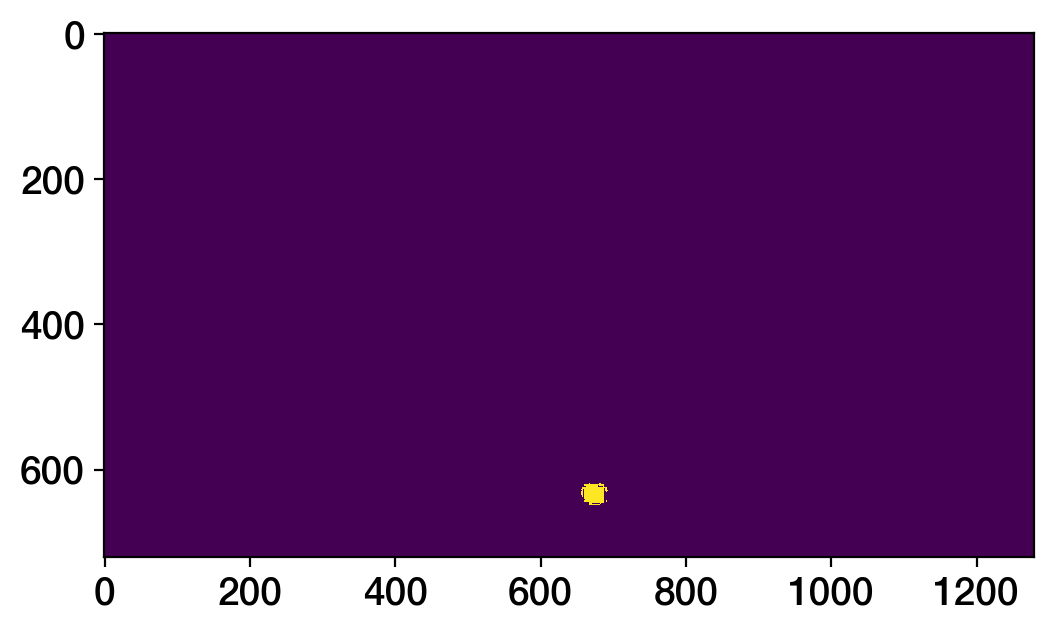

In [10]:
im_foot = (saturation >= 0.6) & (hue > 0.1) & (hue < 0.3)
pl.imshow(im_foot)

## Find centroids of markers

Find the centroid of any binary region using `skimage`

In [11]:
im_label = skimage.measure.label(im_foot)
regions = skimage.measure.regionprops(im_label)

In [12]:
len(regions)

3

There should be only one!

Let's take a closer look…

(600, 700)

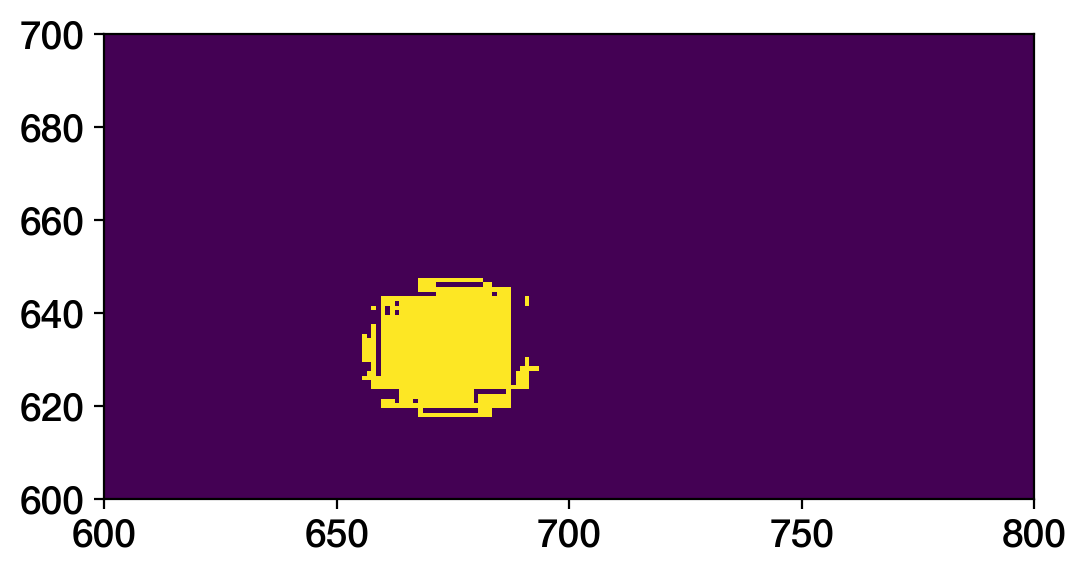

In [13]:
pl.imshow(im_foot)
pl.xlim(600, 800)
pl.ylim(600, 700)

### Remove spurious regions

In [14]:
# Everything with an area less than 50 pixels
im_foot = skimage.morphology.remove_small_objects(im_foot, 50)

(600, 700)

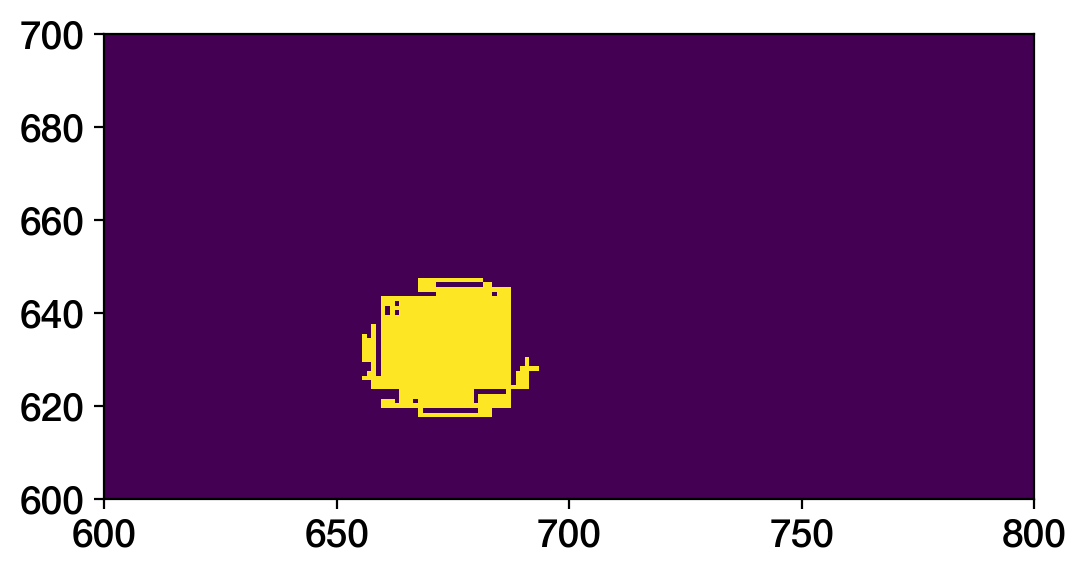

In [15]:
pl.imshow(im_foot)
pl.xlim(600, 800)
pl.ylim(600, 700)

In [16]:
im_label = skimage.measure.label(im_foot)
regions = skimage.measure.regionprops(im_label)
len(regions)

1

In [17]:
regions[0].centroid

(632.1369509043927, 673.673126614987)

## Define function and extract coordinates

Bring together everything we've done

In [18]:
def find_spot(im_binary, min_area=50):
    """Return x, y centroid of a large blob in a binary image."""
    im_cleaned = skimage.morphology.remove_small_objects(im_binary, min_area)
    im_label = skimage.measure.label(im_cleaned)
    regions = skimage.measure.regionprops(im_label)
    if len(regions) != 1:
        raise ValueError('Image must have exactly one large region.')
    y, x = regions[0].centroid
    return x, y

In [19]:
pos_knee_list, pos_foot_list = [], []

for im in frames:
    hsv = skimage.color.rgb2hsv(im)
    hue, saturation, luminance = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    im_knee = (saturation >= 0.2) & (hue > 0.4) & (hue < 0.6)
    im_foot = (saturation >= 0.6) & (hue > 0.1) & (hue < 0.3)
    pos_knee_list.append(find_spot(im_knee))
    pos_foot_list.append(find_spot(im_foot))

In [20]:
for pos in pos_knee_list:
    print(pos)

(834.5211538461539, 347.80961538461537)
(849.4077868852459, 298.01229508196724)
(842.3064516129032, 327.9233870967742)
(799.4226804123712, 407.1567010309278)
(685.2436647173489, 483.35087719298247)


# Analyze previously-found coordinates

In another notebook, we analyze the full movie (~4500 frames) and save the results to disk.

Effective frame rate = 120 frames/s.

In [21]:
coords = pd.read_csv('dbl_pend_120fps_coords.csv')
coords.drop(columns=['Unnamed: 0'], inplace=True)
coords.head()

xfoot     yfoot       xknee       yknee
0  891.814815  8.723457  823.686722  144.983402
1  894.436031  8.449086  822.179752  142.423554
2  895.895141  8.485934  821.504202  140.754202
3  897.445000  8.512500  821.114919  140.010081
4  900.036842  8.500000  820.781971  139.383648

The markers oscillate!

Text(0.5, 0, 'Frame')

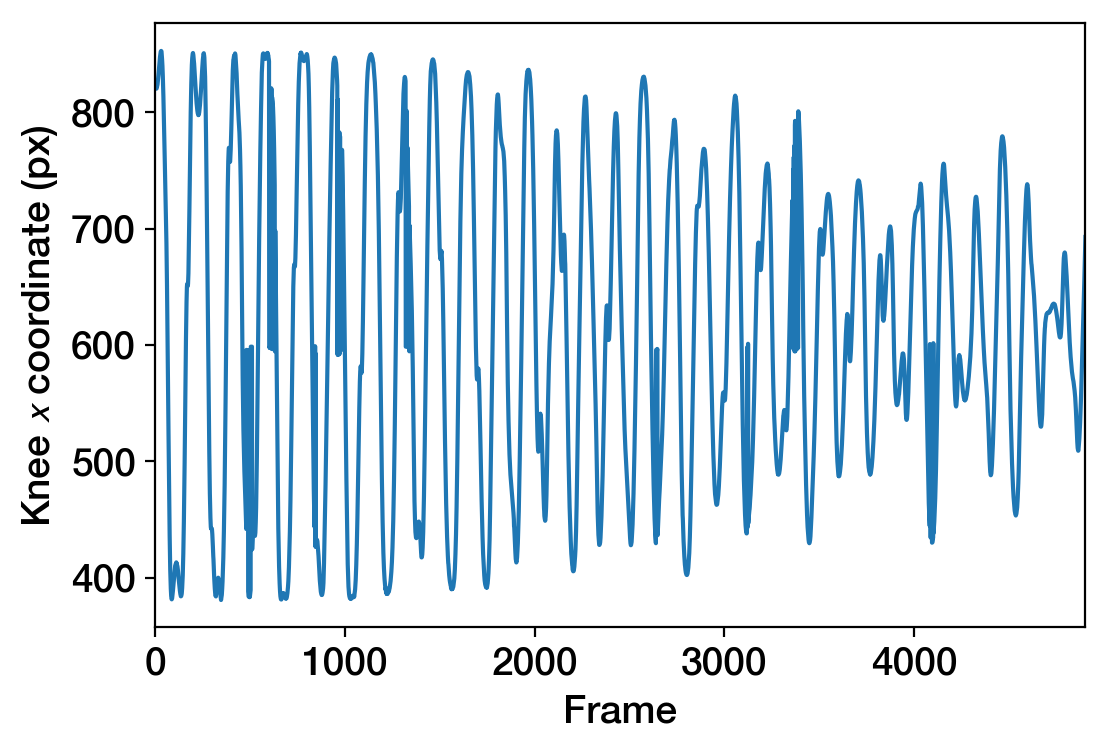

In [22]:
coords.xknee.plot()
pl.ylabel('Knee $x$ coordinate (px)')
pl.xlabel('Frame')

## Put into a "centered" coordinate system

Text(0.5, 0, 'Frame')

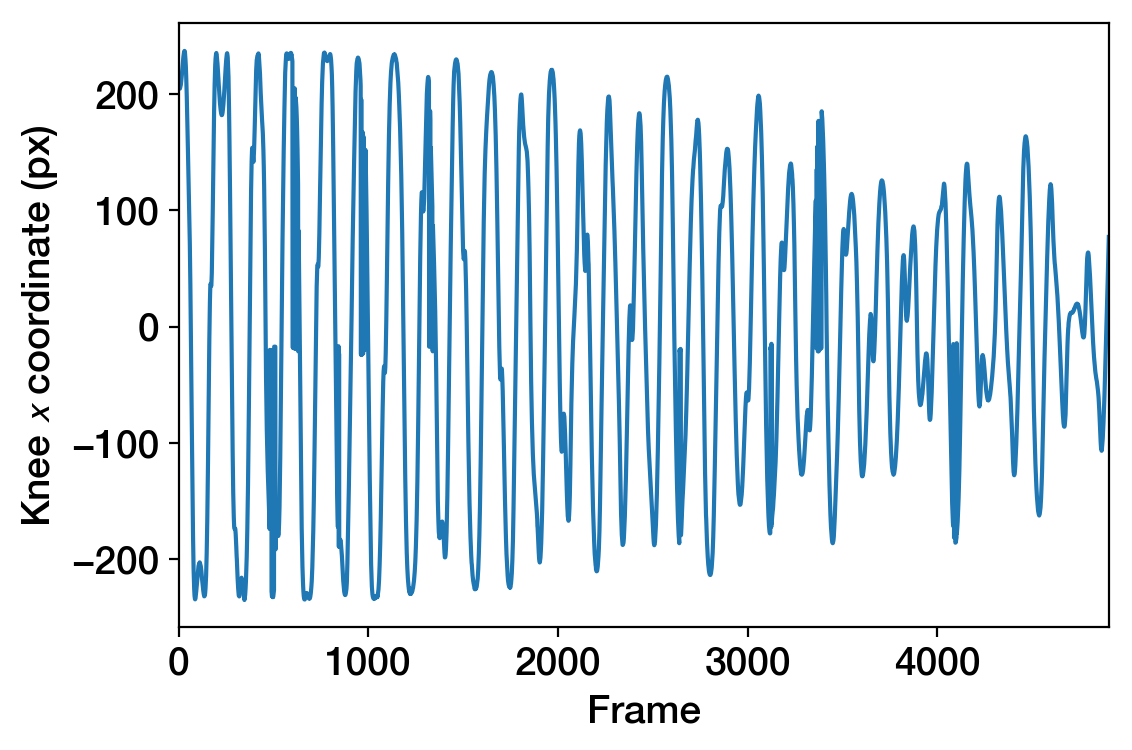

In [23]:
coords_centered = coords - coords.mean()
coords_centered.xknee.plot()
pl.ylabel('Knee $x$ coordinate (px)')
pl.xlabel('Frame')

## Trajectory

Text(0.5, 1.0, 'Pendulum foot trajectory')

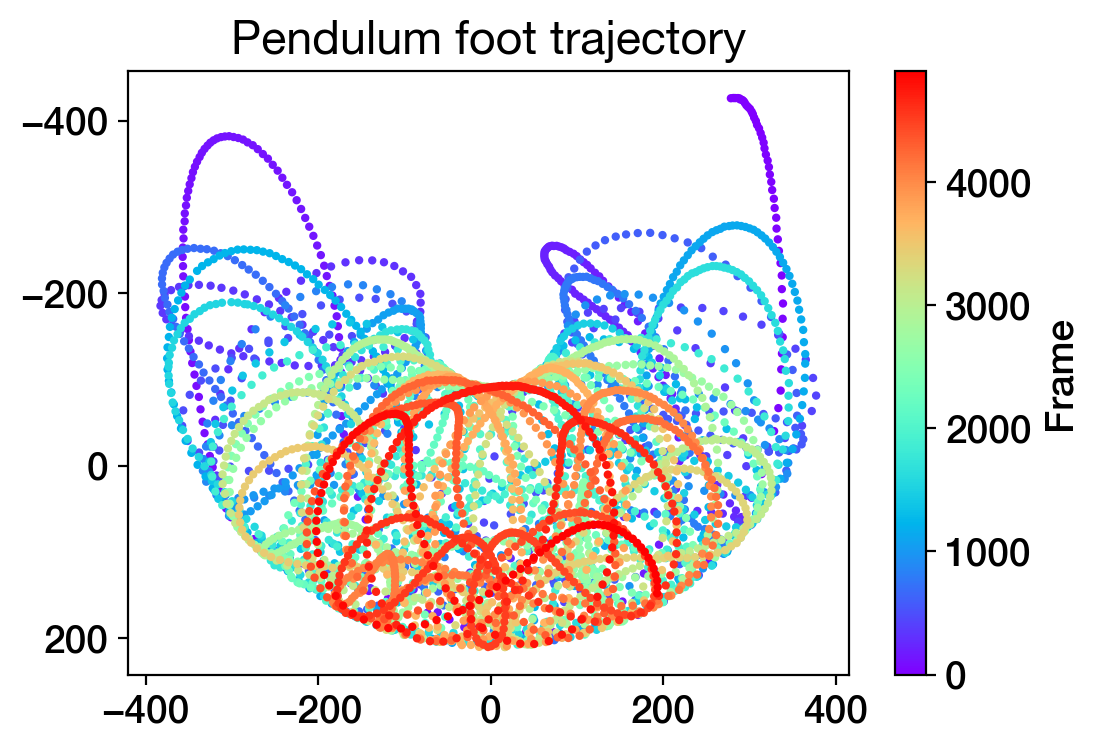

In [24]:
pl.scatter(coords_centered['xfoot'], coords_centered['yfoot'], c=range(len(coords_centered)), cmap=pl.cm.rainbow, s=4)
pl.axis('image')
pl.ylim(*pl.ylim()[::-1])
pl.colorbar(label='Frame')
pl.title('Pendulum foot trajectory')

### Color by speed

Text(0.5, 1.0, 'Pendulum foot trajectory')

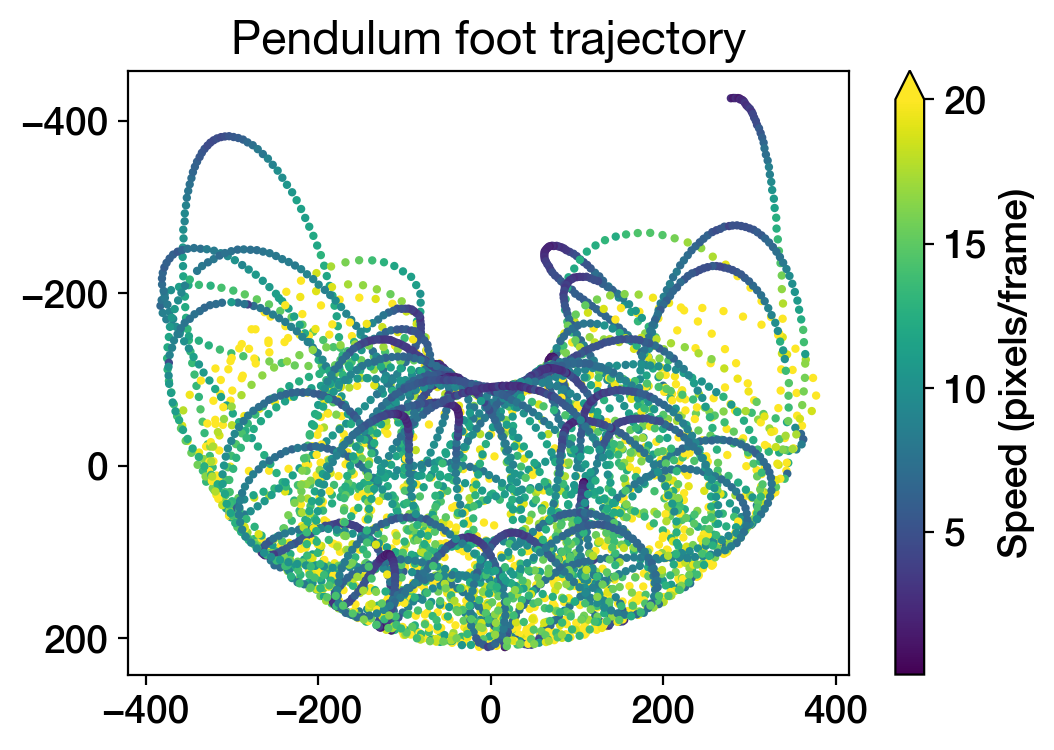

In [25]:
pl.scatter(coords_centered.xfoot.iloc[:-1], 
           coords_centered.yfoot.iloc[:-1], 
           c=np.sqrt(np.diff(coords_centered.xfoot)**2 + 
                     np.diff(coords_centered.yfoot)**2), 
           s=4, vmax=20)
pl.axis('image')
pl.ylim(*pl.ylim()[::-1])
pl.colorbar(label='Speed (pixels/frame)', extend='max')
pl.title('Pendulum foot trajectory')

## Phase portrait of the "knee"

Text(0.5, 0, '$x_\\mathrm{knee}$')

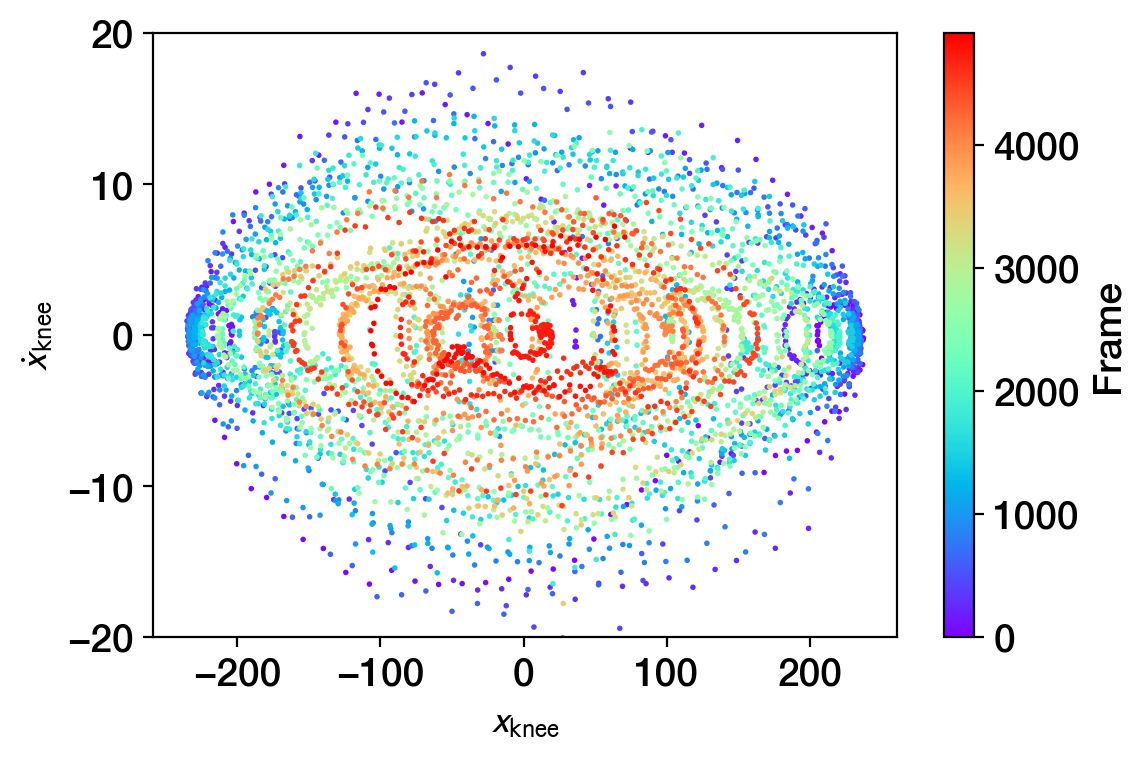

In [26]:
pl.scatter(coords_centered['xknee'].iloc[:-1], np.diff(coords_centered['xknee']),
          s=1, c=range(len(coords_centered) - 1), cmap=pl.cm.rainbow)
pl.ylim(-20, 20)
pl.colorbar(label='Frame')
pl.ylabel(r'$\dot x_\mathrm{knee}$')
pl.xlabel(r'$x_\mathrm{knee}$')

## "Foot" angle

Text(0, 0.5, 'Angle of lower segment (revolutions)')

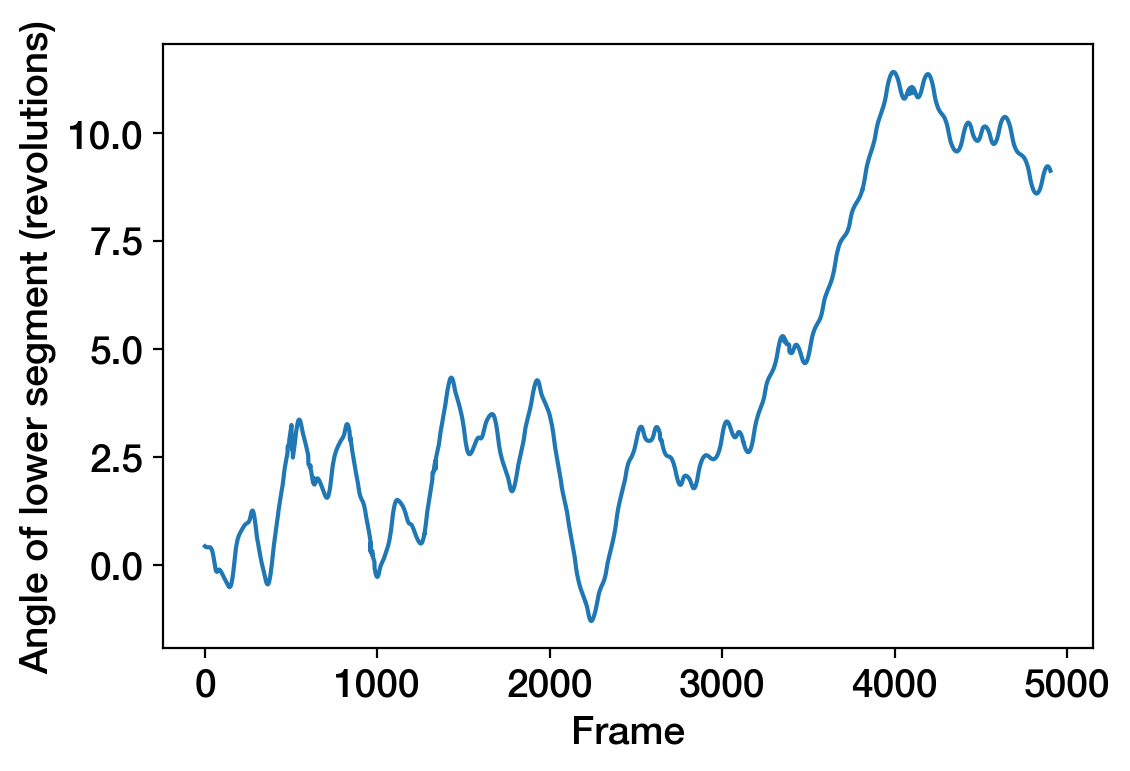

In [27]:
foot_angle = np.unwrap(np.arctan2(
    coords['xfoot'] - coords['xknee'], 
    coords['yfoot'] - coords['yknee'])) / 2 / np.pi
pl.plot(foot_angle)
pl.xlabel('Frame')
pl.ylabel('Angle of lower segment (revolutions)')

# Determine angles at joints

## Angle at base

To get angle at the base of the pendulum $\phi_\text{base}$ (where it's attached to the table), need coordinates of the joint.

Open a frame in ImageJ (or just eyeball) to find

(500, 200)

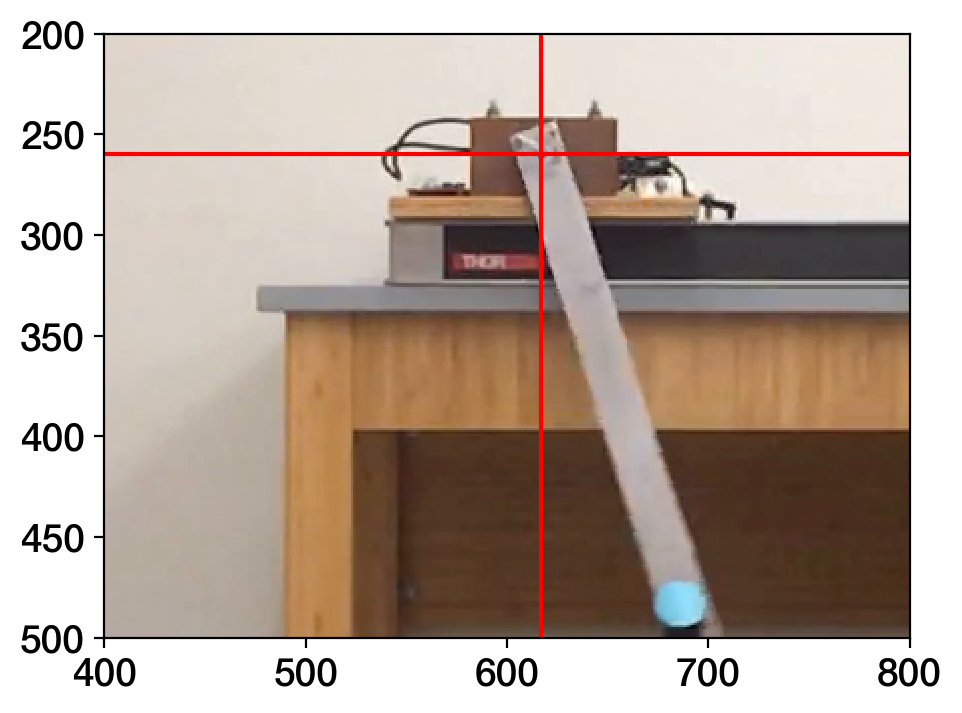

In [28]:
center = 617, 260

# Show it
pl.imshow(im)
pl.axvline(center[0], color='r')
pl.axhline(center[1], color='r')
pl.xlim(400, 800)
pl.ylim(500, 200)

Use `unwrap` to let angle go outside $[-\pi, \pi]$. Convert to revolutions.

Text(0.5, 0, 'Frame')

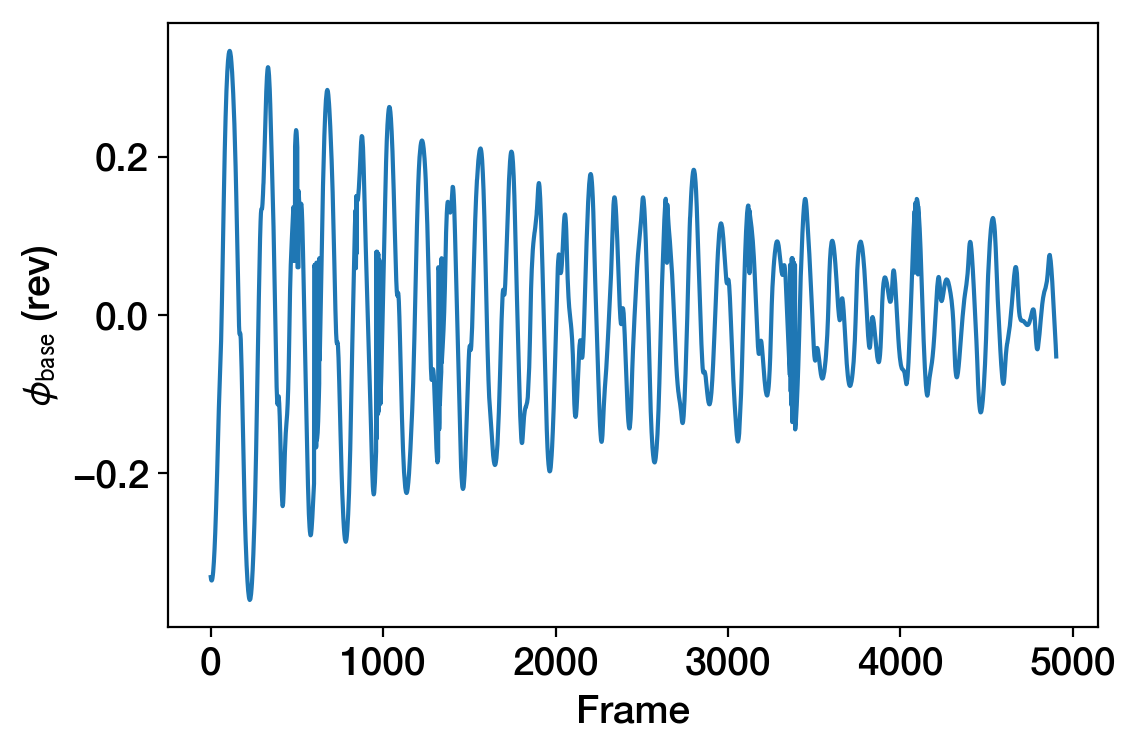

In [29]:
base_angle = np.unwrap(np.arctan2(
    -(coords.xknee - center[0]), coords.yknee - center[1])) / 2 / np.pi

pl.plot(base_angle)
pl.ylabel(r'$\phi_\mathrm{base}$ (rev)')
pl.xlabel('Frame')

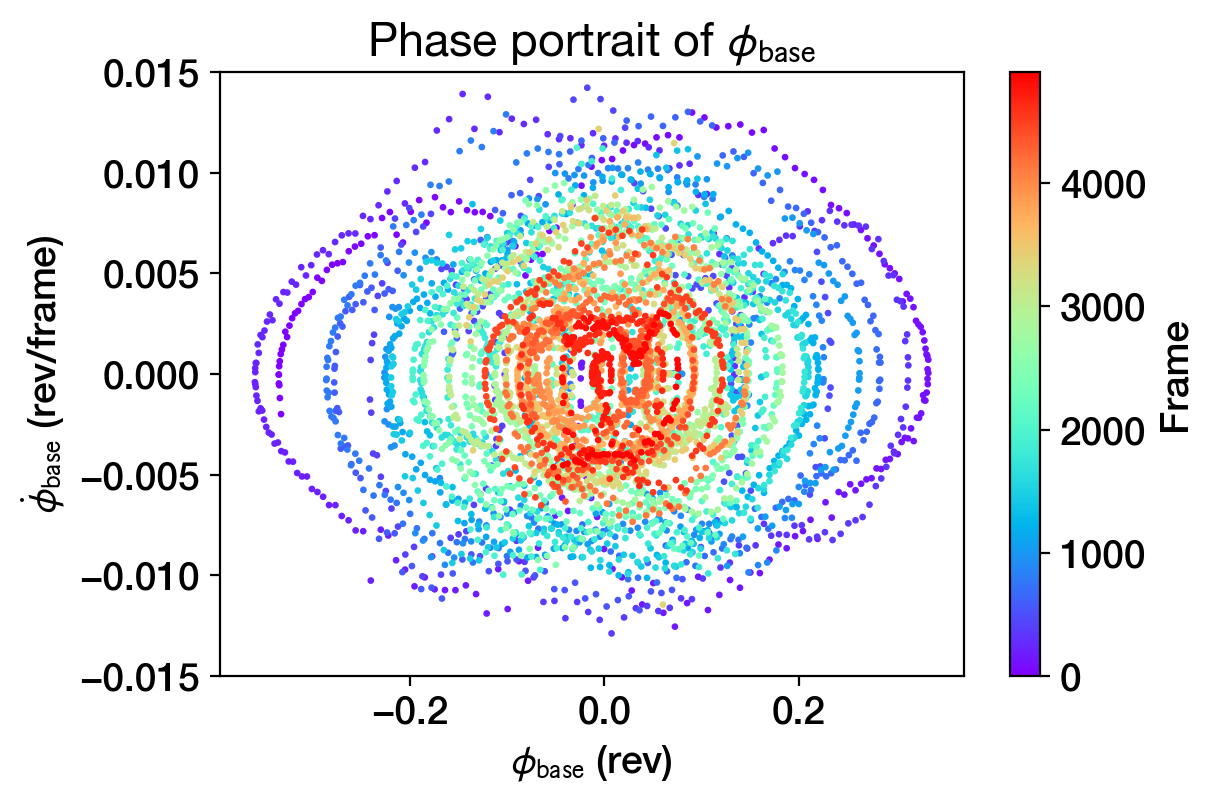

In [30]:
pl.scatter(base_angle[1:], np.diff(base_angle), 
           c=range(len(base_angle) - 1), cmap=pl.cm.rainbow, s=2)
pl.ylim(-0.015, 0.015)
pl.colorbar(label='Frame')
pl.title(r'Phase portrait of $\phi_\mathrm{base}$')
pl.xlabel(r'$\phi_\mathrm{base}$ (rev)')
pl.ylabel(r'$\dot \phi_\mathrm{base}$ (rev/frame)');

The phase portrait vaguely resembles an inward spiral, which would be the behavior of a single pendulum.

## Orientation of the lower segment

Text(0, 0.5, 'Angle of lower segment (revolutions)')

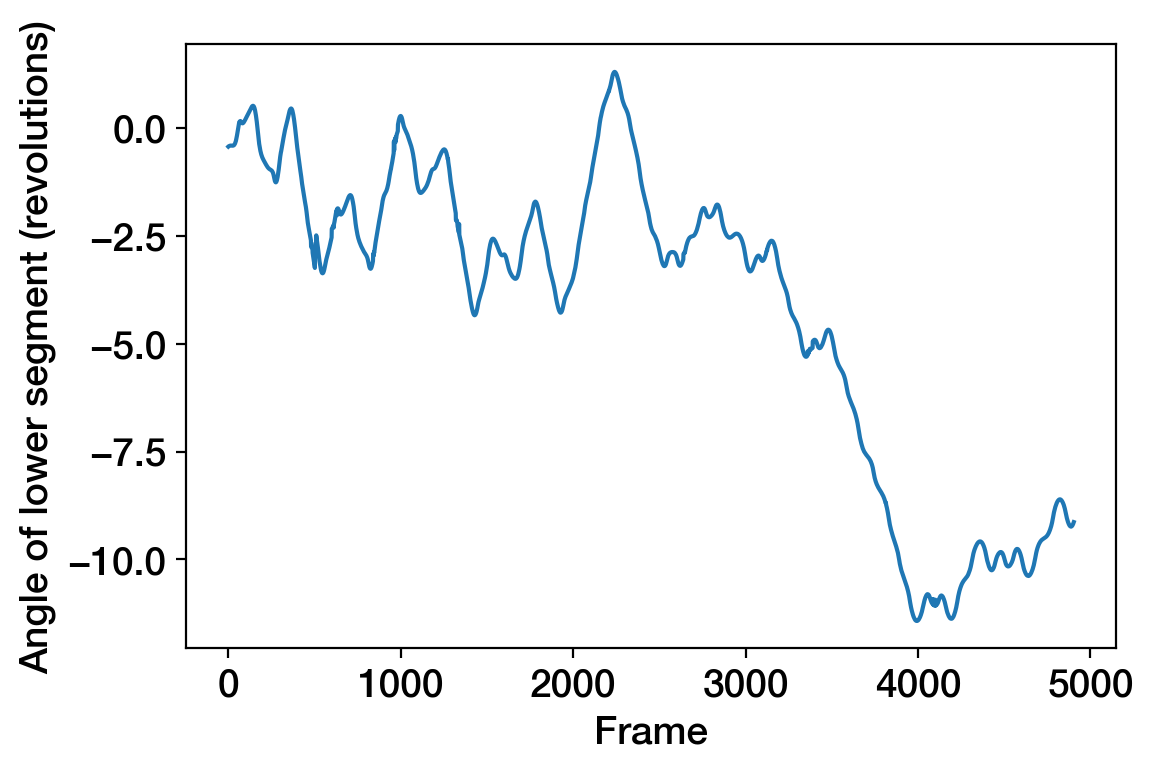

In [31]:
foot_angle = np.unwrap(np.arctan2(
    -(coords['xfoot'] - coords['xknee']), 
    coords['yfoot'] - coords['yknee'])) / 2 / np.pi
pl.plot(foot_angle)
pl.xlabel('Frame')
pl.ylabel('Angle of lower segment (revolutions)')

## Angle at "knee"

$\phi_\text{knee} = 0 \to$ pendulum completely straight.

In [32]:
knee_angle = foot_angle - base_angle

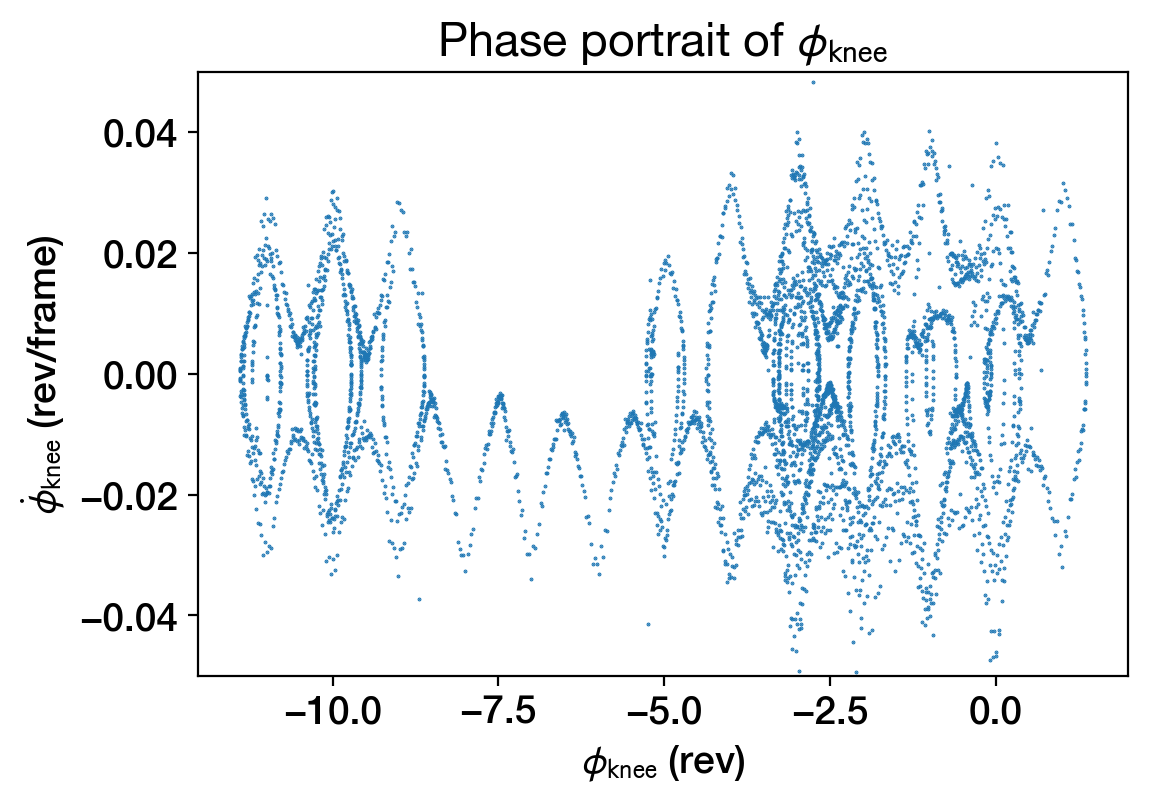

In [33]:
pl.plot(knee_angle[1:], np.diff(knee_angle), '.', ms=0.8)
pl.ylim(-0.05, 0.05)
pl.title(r'Phase portrait of $\phi_\mathrm{knee}$')
pl.xlabel(r'$\phi_\mathrm{knee}$ (rev)')
pl.ylabel(r'$\dot \phi_\mathrm{knee}$ (rev/frame)');

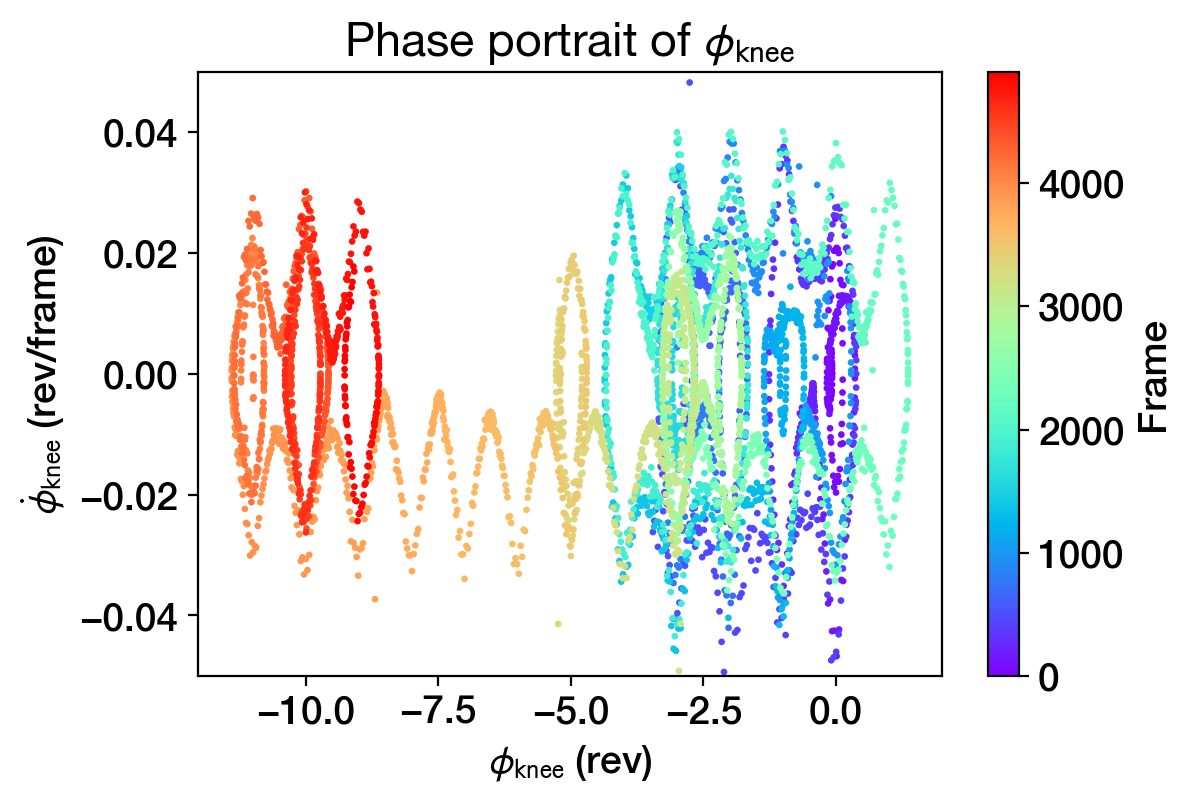

In [34]:
pl.scatter(knee_angle[1:], np.diff(knee_angle), 
           c=range(len(knee_angle) - 1), cmap=pl.cm.rainbow, s=2)
pl.ylim(-0.05, 0.05)
pl.colorbar(label='Frame')
pl.title(r'Phase portrait of $\phi_\mathrm{knee}$')
pl.xlabel(r'$\phi_\mathrm{knee}$ (rev)')
pl.ylabel(r'$\dot \phi_\mathrm{knee}$ (rev/frame)');

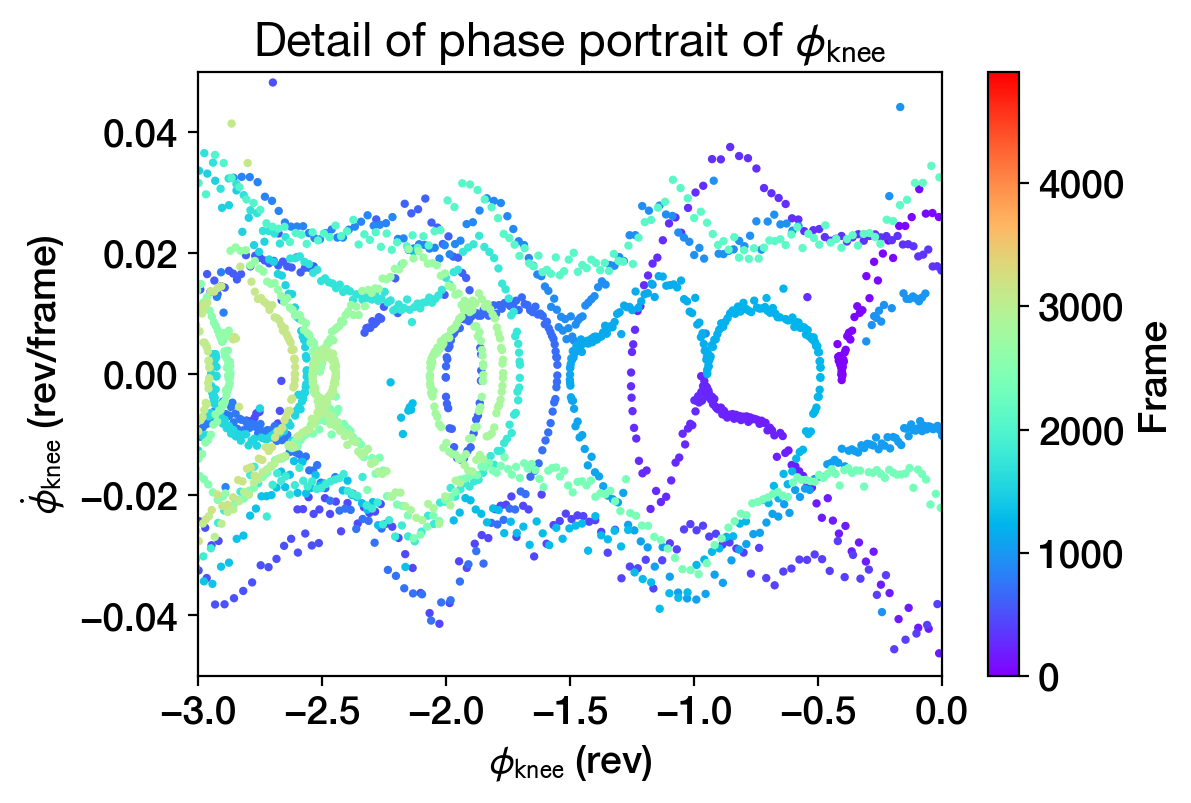

In [35]:
pl.scatter(foot_angle[1:], np.diff(foot_angle), 
           c=range(len(foot_angle) - 1), cmap=pl.cm.rainbow, s=4)
pl.xlim(-3, 0)
pl.ylim(-0.05, 0.05)
pl.colorbar(label='Frame')
pl.title(r'Detail of phase portrait of $\phi_\mathrm{knee}$')
pl.xlabel(r'$\phi_\mathrm{knee}$ (rev)')
pl.ylabel(r'$\dot \phi_\mathrm{knee}$ (rev/frame)');

The phase portrait has some apparent saddle points (e.g. at $\phi = 1.5$ rev., $\dot \phi = 0$) that are unstable and that the system must always go around. 

However that can't be stated rigorously since $\phi_\text{knee}$ is not the only coordinate.